Using tutorial:
    https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [205]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

#Visualizing pictures
from skimage import io
from skimage import exposure
import skimage.color as color
import math

In [343]:
#path = '/Users/dianaaguilar/Documents/GitHub/frogFun/sampleImages/AllProcessed/'
#path = '/Users/dianaaguilar/Documents/GitHub/frogFun/ProcessedImages/Grayscale/'
path = '/Users/dianaaguilar/Documents/GitHub/frogFun/ProcessedImages/BinaryGlare/'
# change the working directory to the path where the images are located
os.chdir(path)


In [344]:
# this list holds all the image filename
frogs = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            frogs.append(file.name)

In [345]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [358]:
def plotGroup(i,name,group=groups[i]):
    n_frogs=len(group)
    fig, axs = plt.subplots(math.ceil(n_frogs/3), 3)
    fig.set_size_inches(18.5, n_frogs)

    n=0
    y=0
    for frog in group:
        if y==3:
            y= 0
            n+=1 
        image = io.imread(path+frog, pilmode='RGBA')
        gamma2=exposure.adjust_log(image)
        gamma3=exposure.adjust_log(gamma2)
        ranita0 = color.rgba2rgb(gamma3) 
        ranita = color.rgb2gray(ranita0) 
    
        axs[n,y].imshow(image,aspect='auto')
        y+=1
    plt.savefig("../../outputFiles/group_"+name+str(i)+".png")
    #plt.savefig("../../outputFiles/group_grayscale"+str(i)+".png")
    #plt.savefig("../../outputFiles/group_binaryk5"+str(i)+".png")

In [346]:
data = {}
#p = '/Users/dianaaguilar/Documents/GitHub/frogFun/outputFiles/frogs.pkl'
#p = '/Users/dianaaguilar/Documents/GitHub/frogFun/outputFiles/frogsgrayscale.pkl'
#p = '/Users/dianaaguilar/Documents/GitHub/frogFun/outputFiles/frogsbinary.pkl'
p = '/Users/dianaaguilar/Documents/GitHub/frogFun/outputFiles/frogsbinaryGlare.pkl'
# lop through each image in the dataset
for frog in frogs:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(frog,model)
        data[frog] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          

In [347]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [348]:
# get a list of just the features
feat = np.array(list(data.values()))
#Reshape
feat = feat.reshape(-1,4096)
#feat.shape

In [349]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [320]:
np.shape(x[0:2])

(2, 50)

In [330]:
remove1st=x[:,2:50]

In [447]:
kmeans = KMeans(n_clusters=6, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=6, random_state=22)

In [448]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [449]:
group=groups[0]

n_frogs=len(group)
n_frogs

path+group[0]

'/Users/dianaaguilar/Documents/GitHub/frogFun/ProcessedImages/BinaryGlare/TB34_binary_glare.png'

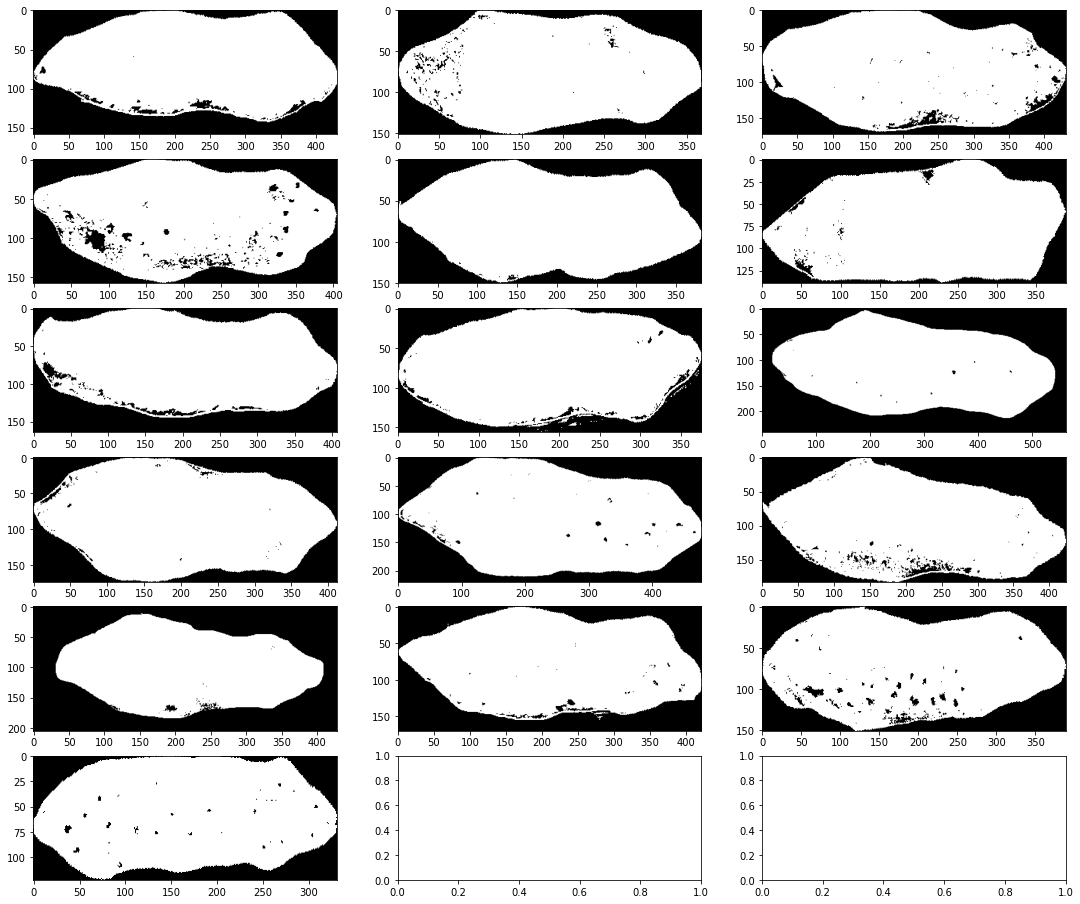

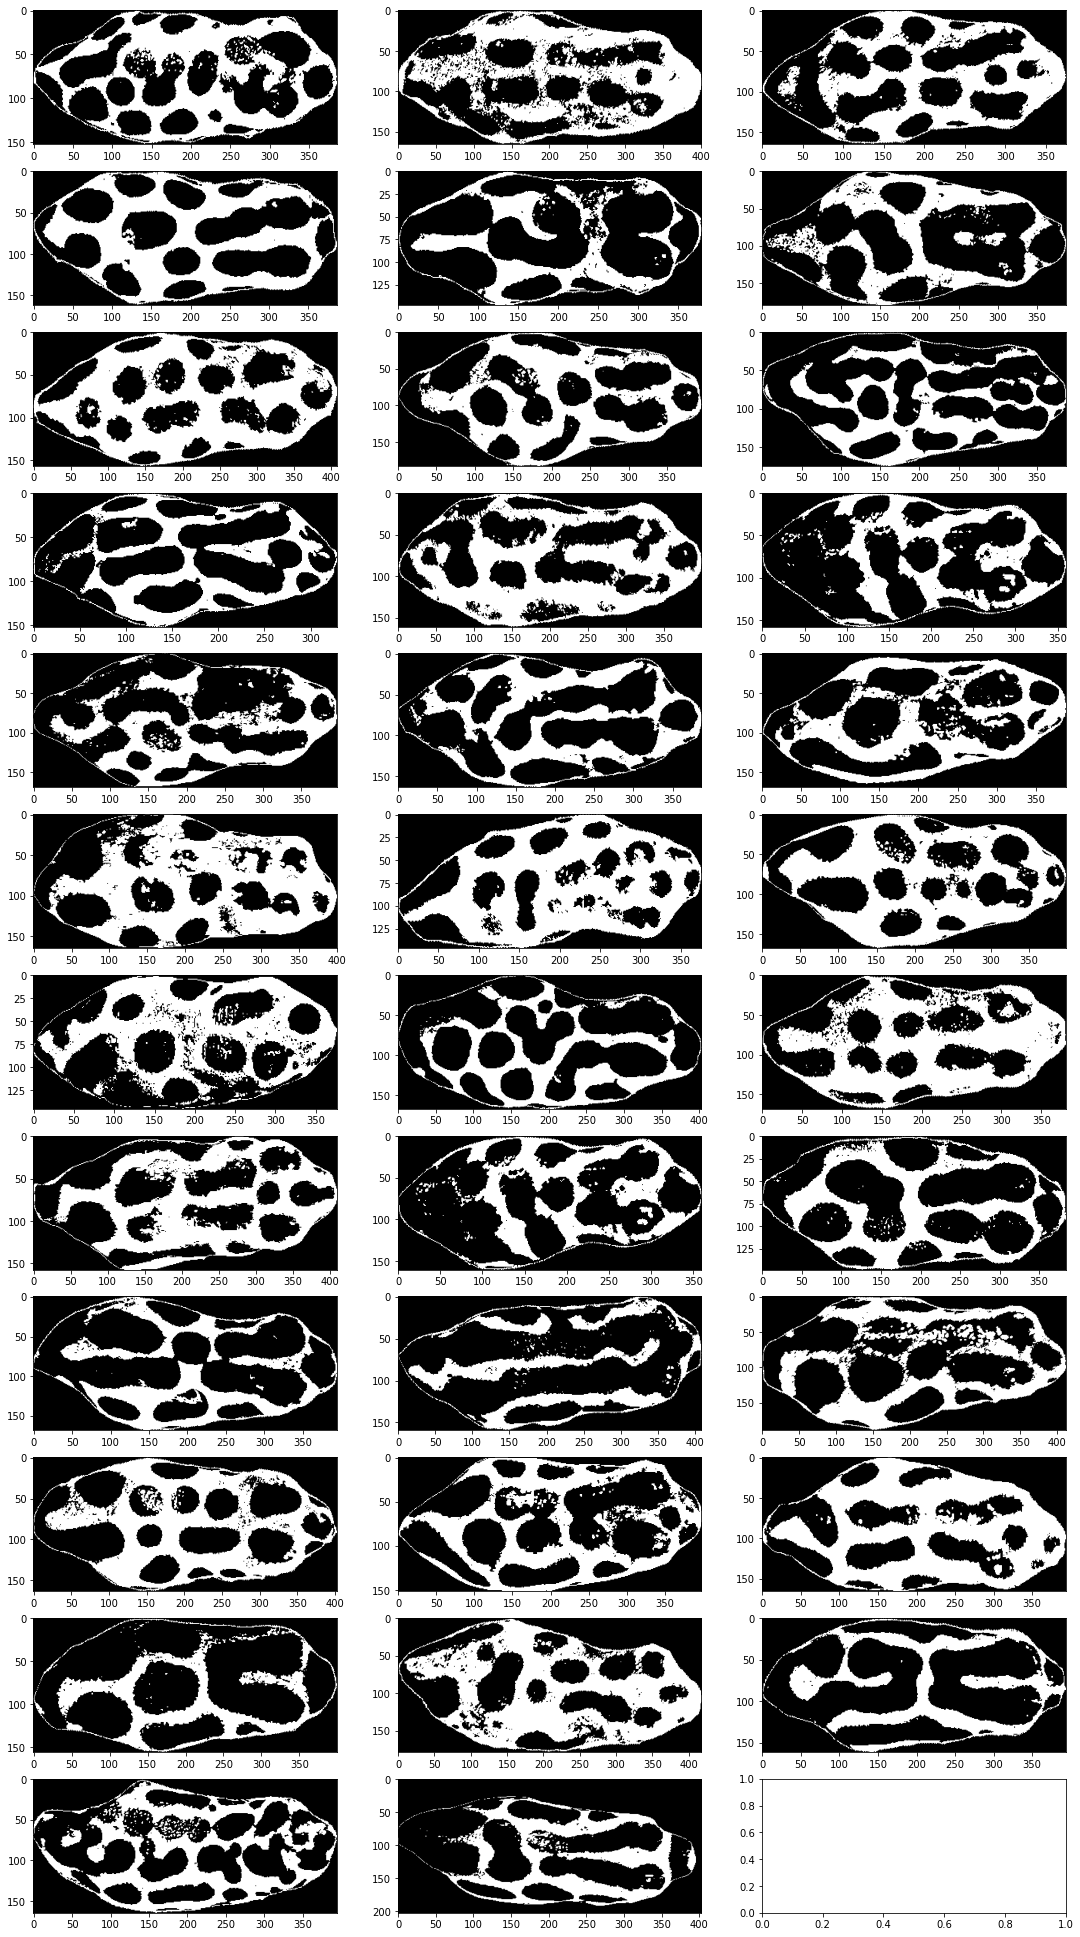

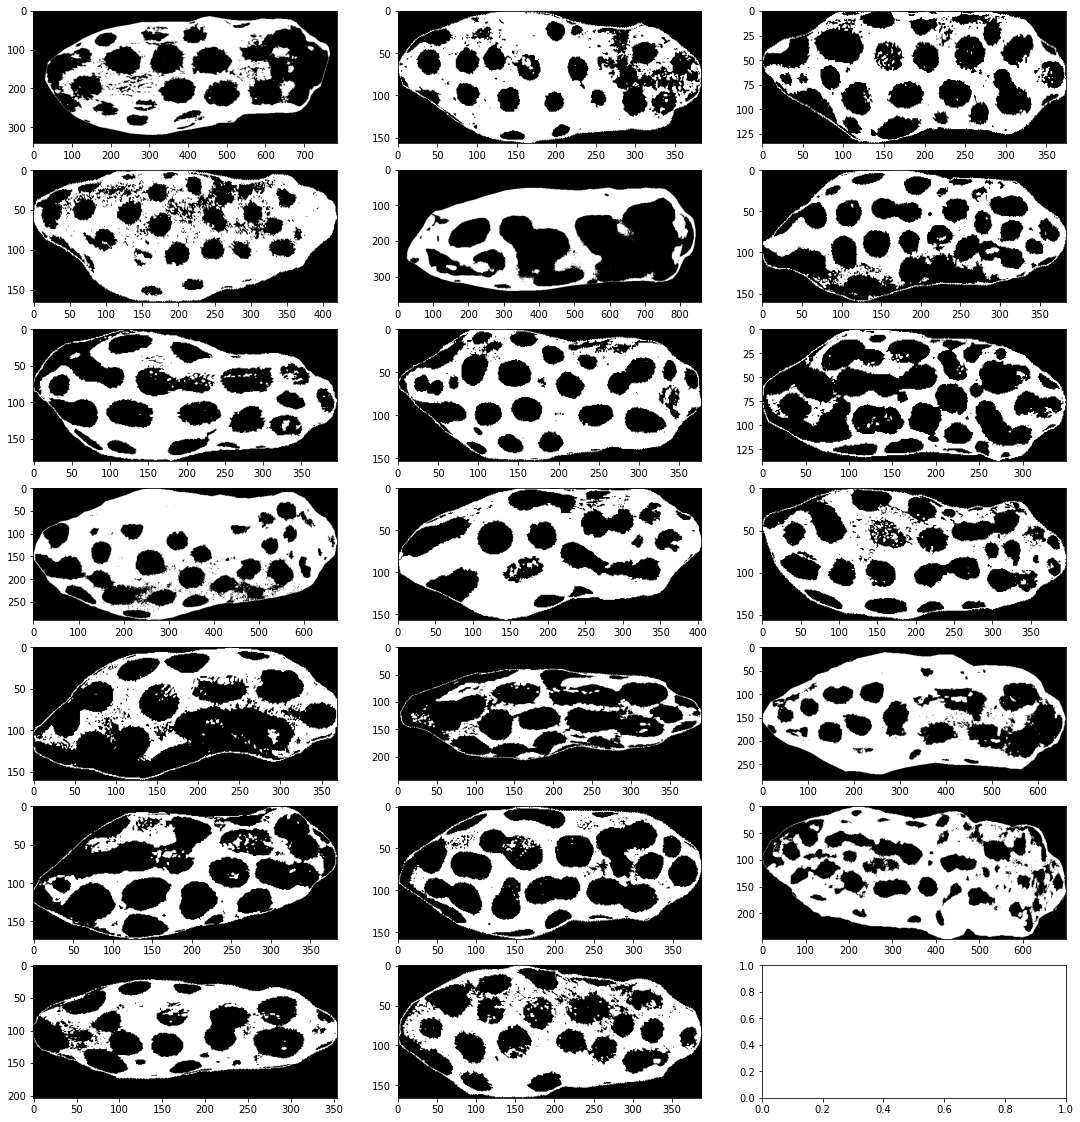

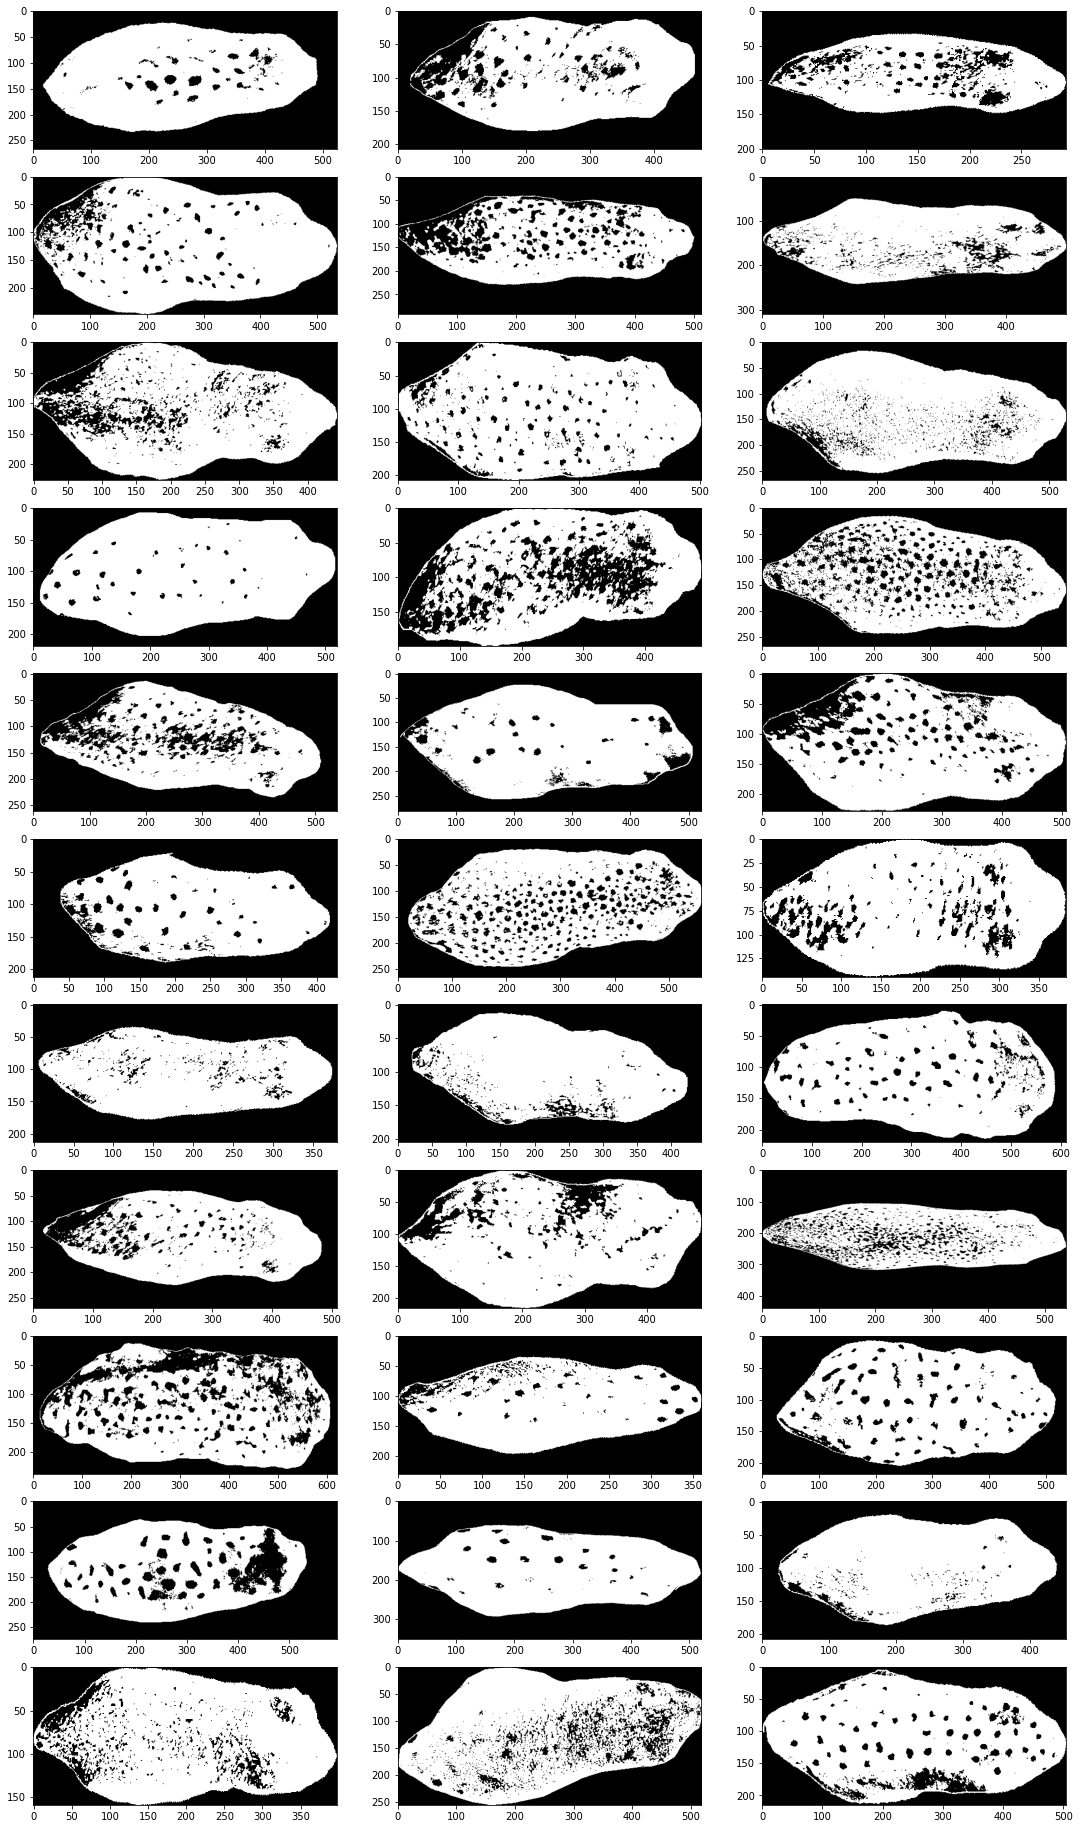

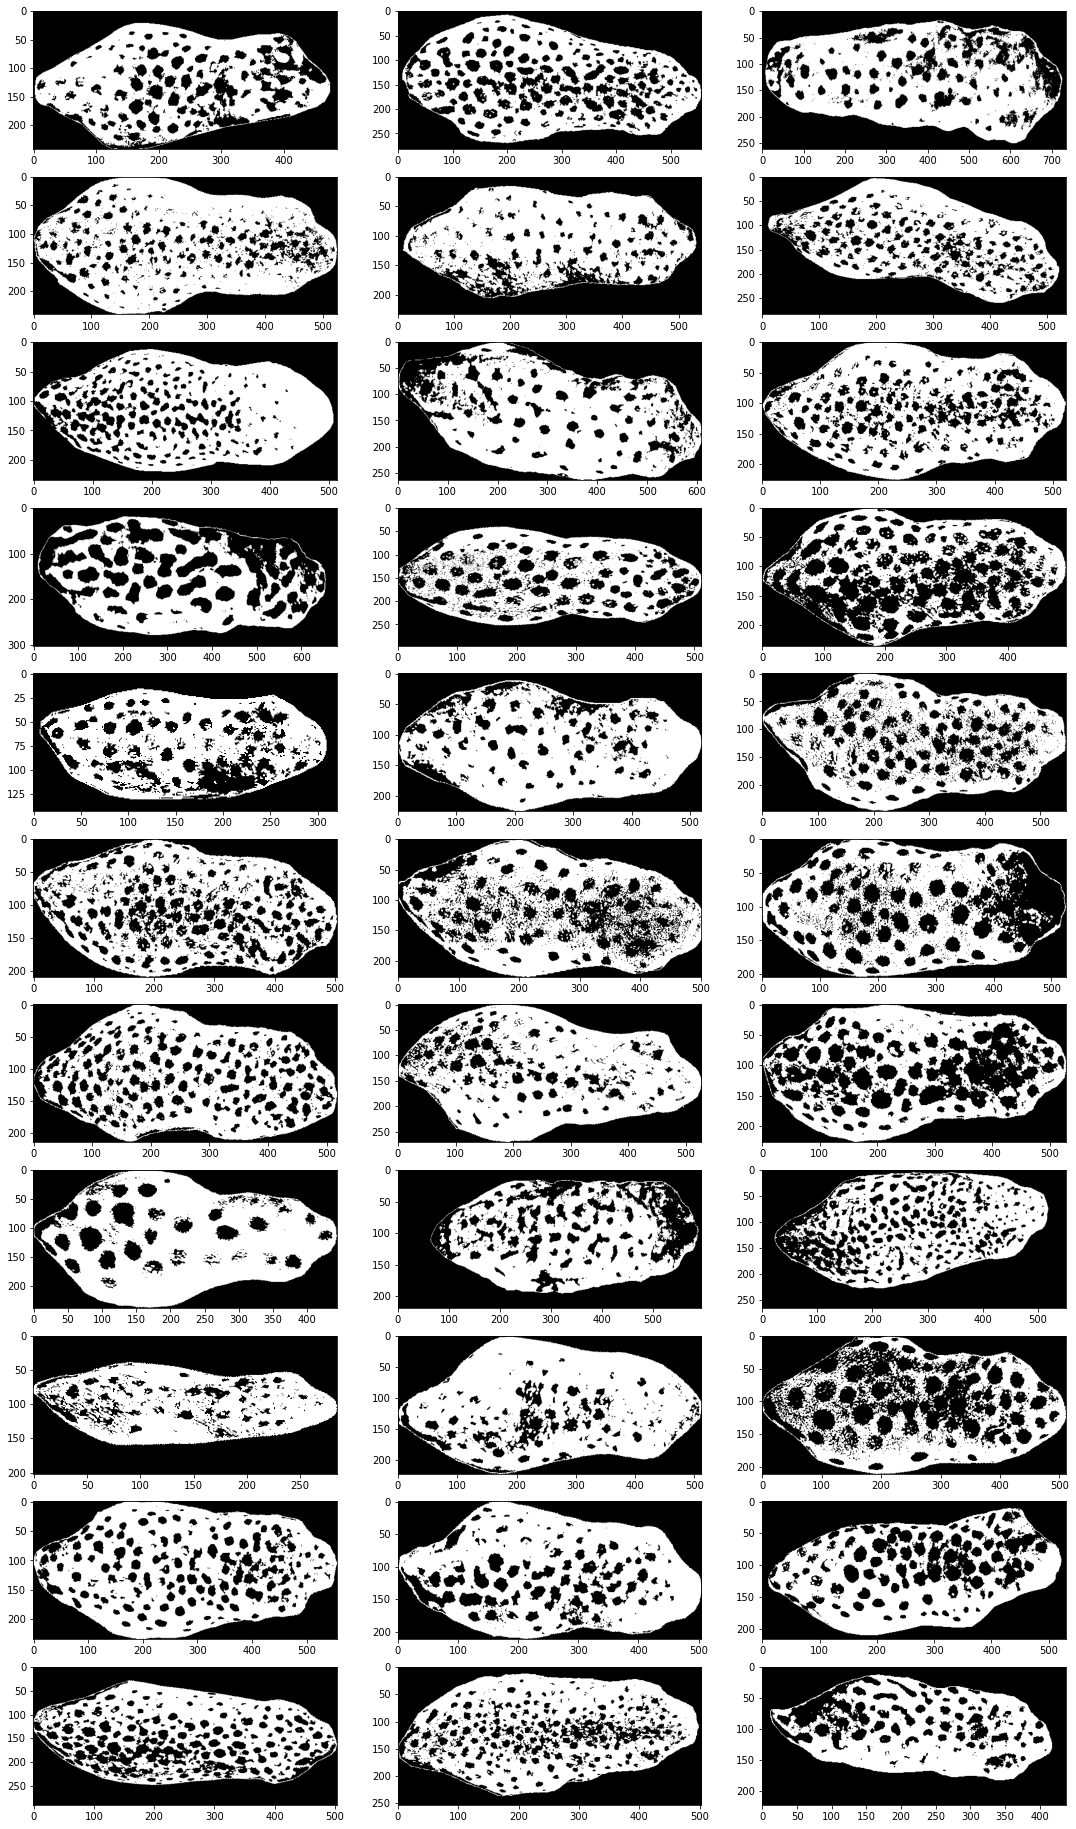

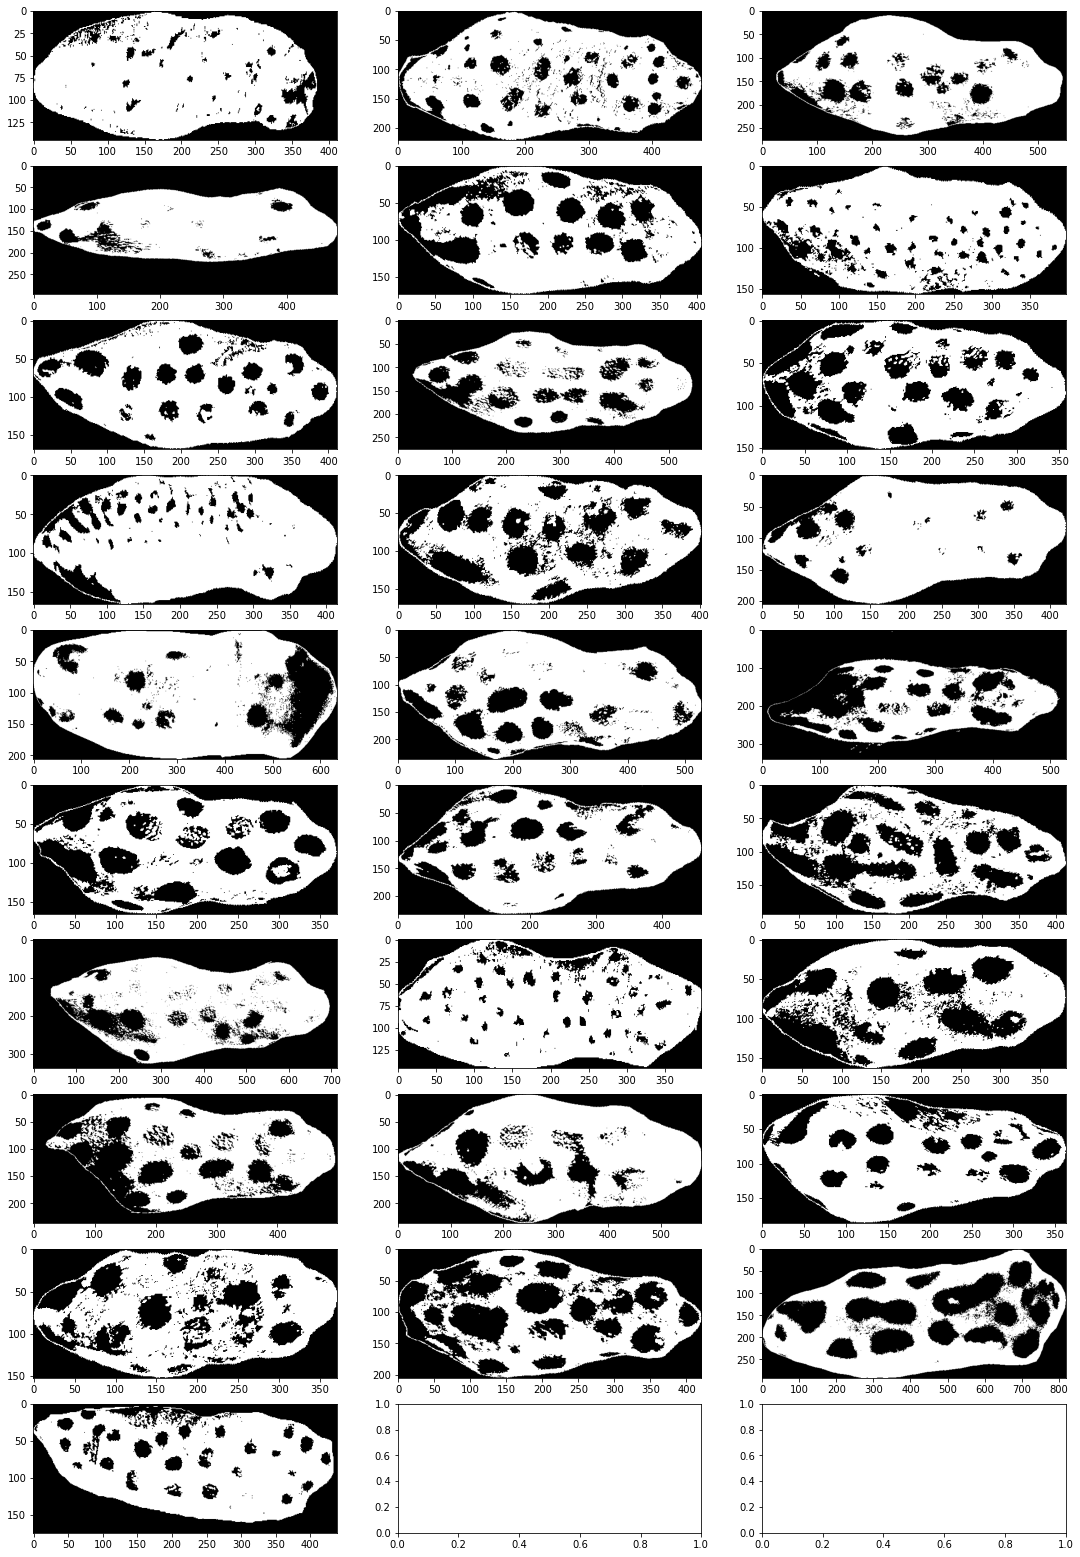

In [450]:
for i in groups:
    plotGroup(i,"binaryGlare_k6_",groups[i])

## Write it down

In [451]:
classes=pd.DataFrame(groups.items(), columns=['classification', 'frog']).explode('frog').reset_index(drop=True)

In [452]:
classes["sample"]=classes.frog.str.rsplit("_",2,expand=True)[0]
classes

classification                       frog    sample
0                 0      TB34_binary_glare.png      TB34
1                 0      TB20_binary_glare.png      TB20
2                 0      TB35_binary_glare.png      TB35
3                 0      TB21_binary_glare.png      TB21
4                 0      TB10_binary_glare.png      TB10
..              ...                        ...       ...
160               3     CMR07_binary_glare.png     CMR07
161               3     CMR26_binary_glare.png     CMR26
162               3     CMR18_binary_glare.png     CMR18
163               3  CM_UN_03_binary_glare.png  CM_UN_03
164               3      CL06_binary_glare.png      CL06

[165 rows x 3 columns]

In [453]:
'''
k=5
2->3
3->4
4->2


k=6
1->5
4->1
5->4
'''

classes["classification"].replace([1,4,5], [5,1,4],inplace=True)


In [454]:
meta=pd.read_table("/Users/dianaaguilar/Documents/GitHub/frogFun/outputFiles/blackprop.tsv")
meta["sample"]=meta.bam.str.rsplit("_",2,expand=True)[0]
meta.head()

pop              bam  mom  dad  sex  class1        B1    S1U  S1V    S1B  \
0  AG   AG01_S94.r.bam    0    0    2      -9  1048.452  0.166  0.2  0.283   
1  AG  AG02_S231.r.bam    0    0    2      -9  1048.452  0.166  0.2  0.283   
2  AG  AG03_S230.r.bam    0    0    2      -9  1048.452  0.166  0.2  0.283   
3  AG  AG04_S188.r.bam    0    0    1      -9  1048.452  0.166  0.2  0.283   
4  AG  AG05_S241.r.bam    0    0    2      -9  1048.452  0.166  0.2  0.283   

     S1G   S1Y    S1R  blackproportion sample  
0  0.257  0.21  0.302             -9.0   AG01  
1  0.257  0.21  0.302             -9.0   AG02  
2  0.257  0.21  0.302             -9.0   AG03  
3  0.257  0.21  0.302             -9.0   AG04  
4  0.257  0.21  0.302             -9.0   AG05

In [455]:
together=pd.merge(meta,classes,on="sample",how="left")
together.head()

pop              bam  mom  dad  sex  class1        B1    S1U  S1V    S1B  \
0  AG   AG01_S94.r.bam    0    0    2      -9  1048.452  0.166  0.2  0.283   
1  AG  AG02_S231.r.bam    0    0    2      -9  1048.452  0.166  0.2  0.283   
2  AG  AG03_S230.r.bam    0    0    2      -9  1048.452  0.166  0.2  0.283   
3  AG  AG04_S188.r.bam    0    0    1      -9  1048.452  0.166  0.2  0.283   
4  AG  AG05_S241.r.bam    0    0    2      -9  1048.452  0.166  0.2  0.283   

     S1G   S1Y    S1R  blackproportion sample  classification frog  
0  0.257  0.21  0.302             -9.0   AG01             NaN  NaN  
1  0.257  0.21  0.302             -9.0   AG02             NaN  NaN  
2  0.257  0.21  0.302             -9.0   AG03             NaN  NaN  
3  0.257  0.21  0.302             -9.0   AG04             NaN  NaN  
4  0.257  0.21  0.302             -9.0   AG05             NaN  NaN

In [456]:
together=together[["pop","bam","mom","dad","sex","class1","B1",\
                   "S1U","S1V","S1B","S1G","S1Y","S1R","blackproportion","classification"]]
together.to_csv(outpath+"binaryglarek6.tsv",sep="\t",index=False,na_rep=-9)

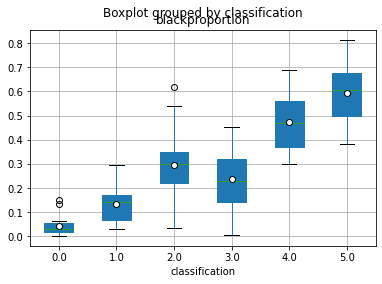

In [457]:
outpath="/Users/dianaaguilar/Documents/GitHub/frogFun/outputFiles/"
together.boxplot(column=["blackproportion"],by="classification",showmeans=True,
                  return_type='dict',patch_artist = True,
                  meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})


plt.savefig(outpath+"ClassGlarek6vsBlackproportion.png")

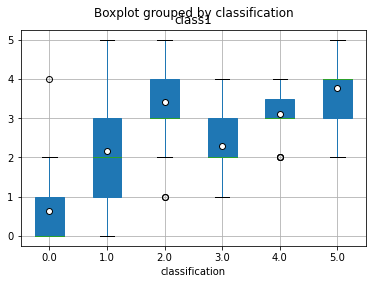

In [458]:
together.boxplot(column=["class1"],by="classification",showmeans=True,
                  return_type='dict',patch_artist = True,
                  meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})


plt.savefig(outpath+"ClassGlarek6vsClass1.png")

B1    {'whiskers': [Line2D(_child1), Line2D(_child2)...
dtype: object

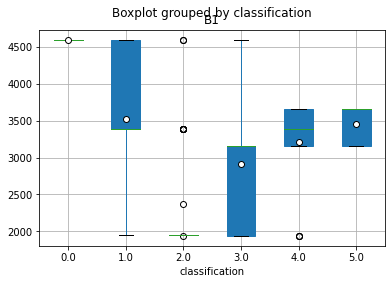

In [461]:
together.boxplot(column=["B1"],by="classification",showmeans=True,
                  return_type='dict',patch_artist = True,
                  meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})